# Projet 8: Déployer un modèle dans le cloud

<p><strong>a. Présentation du projet</strong></p>
<p>Ce projet s'inscrit dans le cadre du développement d'une application mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit.</p>
<p>L'objectif de ce projet est de développer un environnement Big Data qui comprendra le preprocessing et une étape de réduction de dimension.<p/>
<p><strong>b. Données</strong></p>
<p>Le jeu de données est un ensemble d'images de fruits et de labels associés : https://www.kaggle.com/moltean/fruits<p/>

## I. Librairies Importation

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.3,databricks:spark-deep-learning:1.5.0-spark2.4-s_2.11 pyspark-shell'

In [2]:
import findspark
findspark.init()

In [3]:
# librairies classiques
import io
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# librairies pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import ArrayType, IntegerType, FloatType, StringType
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import StandardScaler,PCA

#librairies tensorflow
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

## II. Configurations

* **AWS Accès**

In [4]:
bucket = 'ocp8s3'
access_id = 'id'
access_key = 'key'
path = 's3a://'+bucket+'/'

* **Spark Session Création**

In [5]:
spark = SparkSession.builder \
        .master('local') \
        .appName('Fruits') \
        .getOrCreate()

In [6]:
hadoop_conf = spark._jsc.hadoopConfiguration()
hadoop_conf.set('fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem')
hadoop_conf.set('fs.s3a.access.key', access_id)
hadoop_conf.set('fs.s3a.secret.key', access_key)

In [7]:
sc = spark.sparkContext

## III. Data Chargement

In [8]:
prefix = 'Dataset/'

* **Fonctions**

In [9]:
def get_label(path_img):
    '''
    - Prend en entrée le chemin d'une image
    - Récupère le label : niveau supérieur du chemin (arbre des données)
    - Retourne le label (tel que donné par Fruits 360)
    '''
    if len(path_img) > 0:
        #catégorie de l'image
        return path_img.split('/')[-2]
    else:
        return ''

In [10]:
def load_data(path_img):
    '''
    - Prend en entrée le chemin d'une image (si image), ou le répertoire des données (si ensemble des images)
    - Lit les données dans le stockage S3, les enregistre sous forme de spark dataframe contenant l'image ou
      l'ensemble d'images, leur(s) chemin(s) et leur(s) label(s)
    - Retourne ce spark dataframe
    '''
    #compteur
    start = time.time()
    
    #chargement dataframe des images    
    df_img = spark.read.format('binaryFile').load(path_img)
    print('-- chargement effectué --')
    
    #catégorisation des images
    udf_categorie = udf(get_label,StringType())
    df_img = df_img.drop('modificationTime','length').withColumn('label',udf_categorie('path'))
    print('Temps de chargement des images : {} secondes'.format(time.strftime('%S', time.gmtime(time.time()-start))))
    
    return df_img

* **Dataset (25 images)**

In [11]:
path_data = path+prefix+'*'

In [12]:
df_img = load_data(path_data)

-- chargement effectué --
Temps de chargement des images : 03 secondes


In [13]:
df_img.show(5)

+--------------------+--------------------+-----+
|                path|             content|label|
+--------------------+--------------------+-----+
|s3a://ocp8s3/Data...|[FF D8 FF E0 00 1...|Peach|
|s3a://ocp8s3/Data...|[FF D8 FF E0 00 1...|Apple|
|s3a://ocp8s3/Data...|[FF D8 FF E0 00 1...|Peach|
|s3a://ocp8s3/Data...|[FF D8 FF E0 00 1...|Apple|
|s3a://ocp8s3/Data...|[FF D8 FF E0 00 1...| Pear|
+--------------------+--------------------+-----+
only showing top 5 rows



Peach


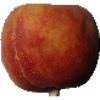

In [14]:
print(df_img.first().label)
Image.open(io.BytesIO(df_img.first().content))

## IV. Analyse

* **Model Preparation**

In [15]:
model = ResNet50(include_top=False,weights=None,pooling='avg')
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [16]:
bc_model_weights = sc.broadcast(model.get_weights())

In [17]:
def model_fn():
    """ 
    Retourne un modèle ResNet50 avec sans la couche supérieure et avec diffusion des poids pré-entraînés
    """
    model = ResNet50(weights=None, include_top=False)
    model.set_weights(bc_model_weights.value)
    return model

* **Preprocess & Featurization**

In [18]:
def preprocess(content):
    '''
    - Retourne des images prétraités pour la prédiction
    '''
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    '''
    - Extraction des features d'un pd.Series d'images brutes à l'aide du modèle d'entrée
    - Retourne un pd.Série de features des images
    '''
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    Cette méthode est une UDF Scalar Iterator pandas enveloppant la fonction d'extraction des features.
    - Prend en entrée "content_series_iter", un itérateur sur des lots de données, où chaque lot est une
      série de pandas de données d'image.
    - Retourne une colonne Spark DataFrame de type ArrayType(FloatType).
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/usr/spark/spark-3.0.3-bin-hadoop2.7/python/pyspark/sql/pandas/functions.py:386: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


In [19]:
df_ftr = df_img.repartition(16).select(col('path'),col('content'),col('label'),
                                       featurize_udf('content').alias('features'))

In [20]:
df_ftr.show(5)

+--------------------+--------------------+------+--------------------+
|                path|             content| label|            features|
+--------------------+--------------------+------+--------------------+
|s3a://ocp8s3/Data...|[FF D8 FF E0 00 1...|Cherry|[0.0, 14.915677, ...|
|s3a://ocp8s3/Data...|[FF D8 FF E0 00 1...| Peach|[0.0, 15.042145, ...|
|s3a://ocp8s3/Data...|[FF D8 FF E0 00 1...|  Pear|[0.018257141, 14....|
|s3a://ocp8s3/Data...|[FF D8 FF E0 00 1...|Cherry|[0.0, 13.263342, ...|
|s3a://ocp8s3/Data...|[FF D8 FF E0 00 1...|Banana|[0.0, 14.280579, ...|
+--------------------+--------------------+------+--------------------+
only showing top 5 rows



* **Reduction Dimension**

In [21]:
# Conversion au format vecteur dense
ud_f = udf(lambda x: Vectors.dense(x), VectorUDT())
df_ftr = df_ftr.withColumn('featuresVct', ud_f('features'))

In [22]:
# Normalisation
scaler = StandardScaler(inputCol='featuresVct',outputCol='featuresStd',
                        withStd=True, withMean=True).fit(df_ftr)
df_sc = scaler.transform(df_ftr)

In [23]:
# Transformation PCA sur les k premières composantes
k=25
pca = PCA(k=k,inputCol='featuresStd',outputCol='featuresPca').fit(df_sc)
df_pca = pca.transform(df_sc)
df_pca = df_pca.filter(df_pca.featuresPca.isNotNull())

In [24]:
df_pca.select(col('features'),col('featuresVct'),col('featuresStd'),col('featuresPca')).show(5)

+--------------------+--------------------+--------------------+--------------------+
|            features|         featuresVct|         featuresStd|         featuresPca|
+--------------------+--------------------+--------------------+--------------------+
|[0.0, 13.786607, ...|[0.0,13.786606788...|[-0.2545462489499...|[-178.60495683676...|
|[0.0, 13.263342, ...|[0.0,13.263341903...|[-0.2545462489499...|[57.3152703321728...|
|[8.7571144E-4, 14...|[8.75711441040039...|[-0.2235875500555...|[94.8506550363394...|
|[0.0, 11.68219, 6...|[0.0,11.682189941...|[-0.2545462489499...|[186.945236921911...|
|[0.0, 13.927928, ...|[0.0,13.927927970...|[-0.2545462489499...|[-118.07431465861...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



* **Variance expliquee**

In [25]:
variance = np.round(100*pca.explainedVariance.toArray(),2).cumsum()
variance

array([26.04, 37.05, 45.59, 52.29, 57.81, 62.48, 67.07, 70.59, 73.85,
       76.92, 79.64, 82.09, 84.32, 86.43, 88.41, 90.2 , 91.74, 93.23,
       94.68, 95.99, 97.21, 98.38, 99.42, 99.99])

Text(1, 87, '90%')

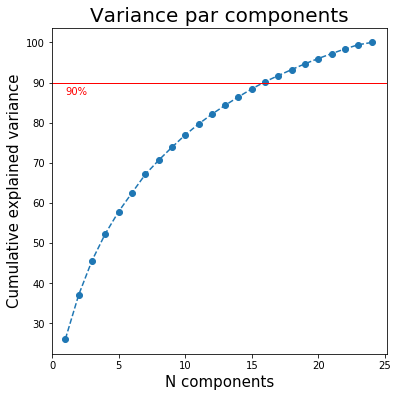

In [29]:
plt.figure(figsize=(6,6))
plt.plot(range(1,k), variance, marker = 'o', linestyle='--')
plt.title('Variance par components',fontsize=20)
plt.xlabel('N components',fontsize=15)
plt.ylabel('Cumulative explained variance',fontsize=15)
plt.xlim(left=0)
plt.axhline(90, lw=1, c='red')
plt.text(1, 87, '90%', c='red')

## V. Sauvegarde Resultats (S3)

In [30]:
df_pca.write.mode('overwrite').parquet(path+'Results/features.parquet')